In [164]:
import hashlib
import sqlite3
import seaborn.apionly as sns
from bs4 import BeautifulSoup
import requests
import re
import string
import pandas as pd

%pylab inline

pd.options.display.max_colwidth = 500
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [1]:
from functools import reduce

url = "https://www.tenderned.nl/over-tenderned/datasets-aanbestedingen"

soup  = BeautifulSoup(requests.get(url).content, "html.parser")

links = [link for link in [a.attrs["href"] for a in soup.find_all("a")] if "Dataset" in link]
links

['https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2016_Q1_Q2.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2016_Q3_Q4_0.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2015.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2014.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2013.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2012.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2010_2011.xlsx']

In [2]:
names = [re.match(r'.*TenderNed_(.*)\.xlsx', link).groups()[0] for link in links]
frames = [pd.read_excel(link) for link in links]

names

['2016_Q1_Q2', '2016_Q3_Q4_0', '2015', '2014', '2013', '2012', '2010_2011']

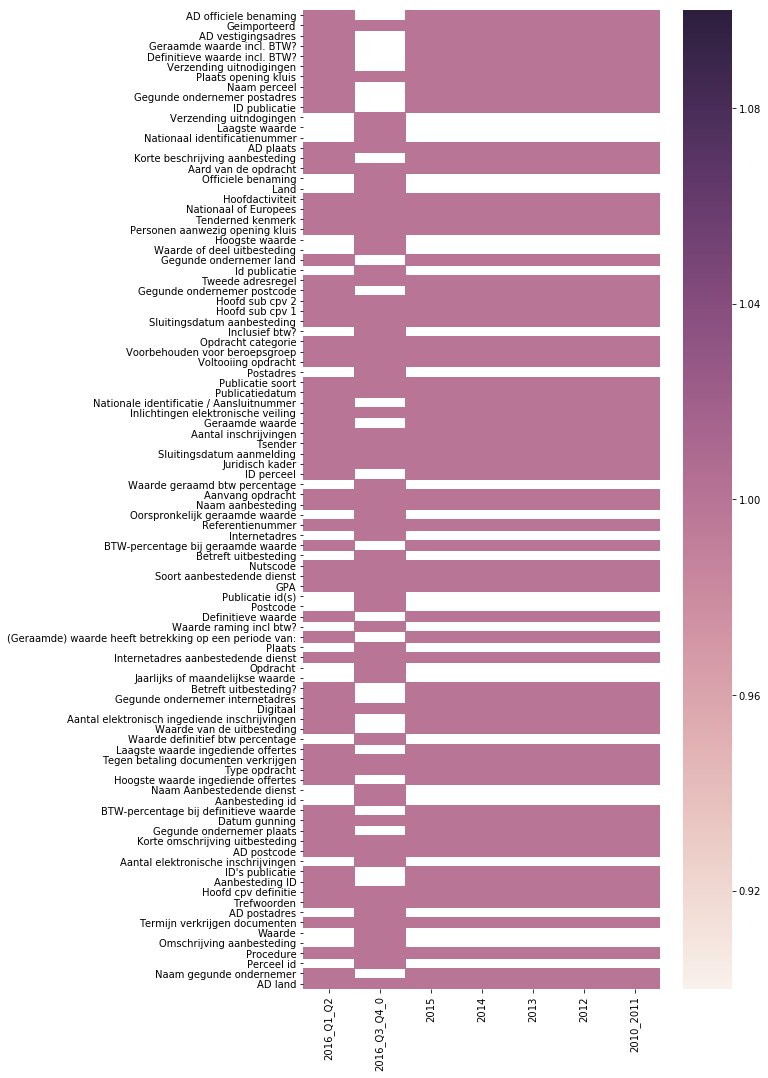

In [4]:
all_columns = set(reduce(lambda x, y: x + y, [list(df.columns) for df in frames]))

missing = pd.DataFrame(index=all_columns)

for name, frame in zip(names, frames):

    missing.loc[frame.columns, name] = 1

plt.figure(figsize = (8, 18))
sns.heatmap(missing)

In [10]:
def sanitize(name):

    t = "".join([c if c in string.ascii_lowercase + string.digits else "_" for c in name.lower()])
    return re.sub(r"_+", "_", t).lstrip("_").rstrip("_")

sanitize(clean_frames[0].columns[-3])

'korte_omschrijving_uitbesteding'

In [170]:
def transform(df, name, link):

    return df.rename(columns=sanitize).assign(
        name = name,
        link = link
    )

clean_frames = [transform(df, name, link) for df, name, link in zip(frames, names, links) if not "2016_Q3" in name]

tenders = pd.concat(clean_frames)
tenders[pd.Series(tenders.columns).sample(5)].head(5)

,tsender,plaats_opening_kluis,id_publicatie,aantal_inschrijvingen,waarde_van_de_uitbesteding
0,NaN,NaN,72152,4.0,NaN
1,NaN,NaN,72154,3.0,NaN
2,NaN,NaN,72155,7.0,NaN
3,NaN,NaN,72156,NaN,NaN
4,NaN,NaN,72157,NaN,NaN


In [171]:
def count_dupes(col):
    return pd.Series({
        "duplications": col.duplicated().sum(),
        "unique_values": len(col.unique()),
        "na": col.isnull().sum(),
        "na + duplications": (col.duplicated() | col.isnull()).sum()
    })

tenders.apply(count_dupes, axis = 0).T.sort_values("duplications")

,duplications,na,na + duplications,unique_values
id_publicatie,14994,0,14994,43295
tenderned_kenmerk,33137,0,33137,25152
aanbesteding_id,33137,0,33137,25152
korte_beschrijving_aanbesteding,35803,51,35804,22486
naam_aanbesteding,36222,0,36222,22067
referentienummer,41271,13614,41272,17018
trefwoorden,48636,10465,48637,9653
naam_gegunde_ondernemer,50474,29203,50475,7815
id_s_publicatie,50999,29203,51000,7290
gegunde_ondernemer_postcode,51968,29432,51969,6321


In [221]:
clean_frames[0][["aanbesteding_id", "definitieve_waarde"]].dropna()

,aanbesteding_id,definitieve_waarde
1,75754,EUR 200000
21,53464,EUR 4776000
39,84790,EUR 290700
61,72334,EUR 200000
73,77197,EUR 186340
91,79246,EUR 55000
93,70402,EUR 50000
96,69755,EUR 245000
97,75879,EUR 65000
98,75879,EUR 65000


In [228]:
pd.concat(clean_frames)[["aanbesteding_id", "definitieve_waarde"]].dropna().set_index("aanbesteding_id").loc[49828]

,definitieve_waarde
aanbesteding_id,
49828,EUR 579158601
49828,EUR 579158601


## Omschrijvingen

* Klein probleempje, postadres heet vestigingsadres in de data

In [12]:
columns = pd.read_excel(
    "https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2016_Q1_Q2.xlsx", 
    sheetname=1, skiprows=10)

columns.sample(5)

,Kolomtitel,Toelichting
2,Publicatiedatum,De datum waarop de aankondiging is gepubliceerd
38,AD plaats,Vestigingsplaats van de aanbestedende dienst
14,Verzending uitnodigingen,De geplande datum waarop onderhandse uitnodigi...
54,Gegunde ondernemer land,Vestigingsland van de ondernemer
49,Aantal elektronisch ingediende inschrijvingen,Het aantal elektronisch (digitaal) ontvangen i...


In [13]:
columns["short_name"] = columns.Kolomtitel.map(sanitize)
columns.sample(5)

,Kolomtitel,Toelichting,short_name
6,Geimporteerd,Is de aankondiging geïmporteerd uit een ander ...,geimporteerd
47,Datum gunning,De datum van de gunning aan de ondernmer(s),datum_gunning
2,Publicatiedatum,De datum waarop de aankondiging is gepubliceerd,publicatiedatum
63,BTW-percentage bij definitieve waarde,De hoogte van het BTW-percentage van de defini...,btw_percentage_bij_definitieve_waarde
18,Nationaal of Europees,Is het een Europese of nationale openbare proc...,nationaal_of_europees


In [17]:
x = set(tenders.columns)
y = set(columns.short_name)

x.difference(y), y.difference(x)

({'ad_vestigingsadres', 'link', 'name'}, {'ad_postadres'})

In [19]:
columns

,Kolomtitel,Toelichting,short_name
0,ID publicatie,"Uniek kenmerk (ID), dat TenderNed toekent aan een aankondiging",id_publicatie
1,Tenderned kenmerk,"Uniek kenmerk (ID), dat TenderNed toekent aan een aanbesteding. Een openbare aanbesteding heeft in de regel meerdere aankondigingen",tenderned_kenmerk
2,Publicatiedatum,De datum waarop de aankondiging is gepubliceerd,publicatiedatum
3,AD officiele benaming,De naam van de aanbestedende dienst,ad_officiele_benaming
4,Nationale identificatie / Aansluitnummer,Het unieke aansluitnummer van een aanbestedende dienst op Tenderned (afgegeven ten tijde van de registratie van de aanbestedende dienst),nationale_identificatie_aansluitnummer
5,Naam aanbesteding,De naam van de aanbesteding,naam_aanbesteding
6,Geimporteerd,Is de aankondiging geïmporteerd uit een ander aanbestedingssysteem (van een Tsender). Dit is technisch mogelijk sinds december 2012.,geimporteerd
7,Tsender,"De naam van het aanbestedingssysteem (de Tsender), waaruit de aankondiging is geïmporteerd. Er zijn twaalf (12) Tsenders",tsender
8,Aanbesteding ID,"Uniek kenmerk (ID), dat TenderNed toekent aan een aanbesteding. Is gelijk aan het TenderNed kenmerk",aanbesteding_id
9,Sluitingsdatum aanmelding,Uiterste datum voor het indienen van een aanmelding (in geval van een niet-openbare procedure),sluitingsdatum_aanmelding


In [172]:
# waardes opschonen

waardes = list(filter(lambda x: ("waarde" in x) and not (("btw" in x) or ("periode" in x)), tenders.columns))

def sanitize_waarde(val):
    if pd.isnull(val): return val
    
    try: 
        return float(val.split(' ')[1])
    except:
        return np.nan
    
tenders.loc[:,waardes] = tenders[waardes].applymap(sanitize_waarde)
tenders[waardes].head(10)

,geraamde_waarde,laagste_waarde_ingediende_offertes,hoogste_waarde_ingediende_offertes,definitieve_waarde,waarde_van_de_uitbesteding
0,NaN,92572.3,120580.0,NaN,NaN
1,200000.0,NaN,NaN,200000.0,NaN
2,180000.0,135000.0,820000.0,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [173]:
plaatsen = pd.Series(tenders.gegunde_ondernemer_plaats.unique())
plaatsen[plaatsen.str.lower().str.contains('ravenh').fillna(False) | plaatsen.str.lower().str.contains('den haa').fillna(False)]

136          Den Haag
154     'S-GRAVENHAGE
274          DEN HAAG
455     's-Gravenhage
476     ‘s Gravenhage
739      s Gravenhage
797          Den haag
1090    's Gravenhage
1165         den Haag
1174    ’S-GRAVENHAGE
1179    ´s-Gravenhage
1189    ’s-Gravenhage
1364     S-Gravenhage
1408    ‘s-Gravenhage
dtype: object

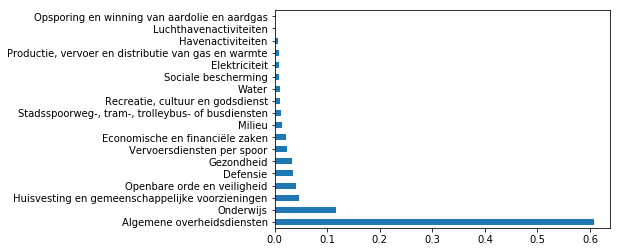

In [175]:
tenders.hoofdactiviteit.value_counts(normalize=True).plot.barh();

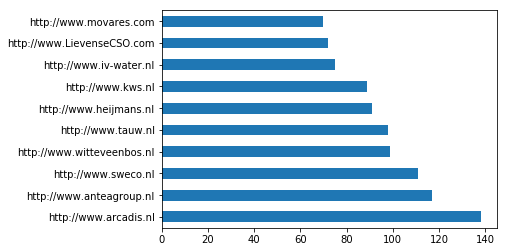

In [177]:
tenders.gegunde_ondernemer_internetadres.value_counts().head(10).plot.barh()

,naam_gegunde_ondernemer,verschil,definitieve_waarde,geraamde_waarde,publicatie_soort,id_s_publicatie,id_perceel,id_publicatie
2250,Driessen B.V.,1.000000,0.01,660000.0,"Kennisgeving van aanvullende informatie, informatie over een onvolledige procedure of rectificatie","81791, 75281, 75783, 72296",NaN,75281
128,Driessen B.V.,1.000000,0.01,660000.0,Aankondiging van een opdracht,"81791, 75281, 75783, 72296",NaN,72296
7033,Driessen B.V.,1.000000,0.01,660000.0,Aankondiging van een gegunde opdracht,"81791, 75281, 75783, 72296",NaN,81791
2656,Driessen B.V.,1.000000,0.01,660000.0,"Kennisgeving van aanvullende informatie, informatie over een onvolledige procedure of rectificatie","81791, 75281, 75783, 72296",NaN,75783
7674,Kramp Nederland B.V.,1.000000,0.01,400000.0,Aankondiging van een opdracht,"38543, 45876",NaN,38543
13339,Kramp Nederland B.V.,1.000000,0.01,400000.0,Aankondiging van een gegunde opdracht,"38543, 45876",NaN,45876
13927,Randstad Payroll Solutions BV,1.000000,1.00,20000000.0,Aankondiging in het geval van vrijwillige transparantie vooraf,46791,NaN,46791
9082,De Persgroep Nederland BV,1.000000,0.01,100000.0,Aankondiging van een gegunde opdracht,"60671, 52125",NaN,60671
2622,De Persgroep Nederland BV,1.000000,0.01,100000.0,Aankondiging van een opdracht,"60671, 52125",NaN,52125
12536,Chubb Fire & Security BV,0.999998,1.00,500000.0,Aankondiging van een gegunde opdracht,44491,NaN,44491


In [190]:
tenders.publicatiedatum = pd.to_datetime(tenders.publicatiedatum)
tenders.aanvang_opdracht = pd.to_datetime(tenders.aanvang_opdracht)

In [213]:
gegund = tenders[tenders.publicatie_soort == 'Aankondiging van een gegunde opdracht'].copy()

gegund["split_id"] = (gegund.id_perceel.astype(str) + gegund.naam_gegunde_ondernemer.astype(str) + gegund.aanbesteding_id.astype(str)).apply(lambda x: hashlib.md5(x.encode('utf-8')).hexdigest())
gegund = gegund[~gegund.split_id.duplicated()].copy()

aanbestedingen = gegund.groupby("aanbesteding_id").agg({
    "naam_aanbesteding": np.unique,
    "definitieve_waarde": min,
    "geraamde_waarde": min,
    "publicatiedatum": min,
    "aanvang_opdracht": min,
    "ad_officiele_benaming": np.unique,
    "hoofdactiviteit": lambda x: x.iloc[0],
    "link": np.unique
})

valid = list(filter(lambda x: any([y in x for y in ["2013", "2014", "2015", "2016_Q1"]]), links))

aanbestedingen = aanbestedingen[aanbestedingen.link.isin(valid)]

print(aanbestedingen.shape)

aanbestedingen.sample(5)

(13885, 8)


,naam_aanbesteding,definitieve_waarde,geraamde_waarde,publicatiedatum,aanvang_opdracht,ad_officiele_benaming,hoofdactiviteit,link
aanbesteding_id,,,,,,,,
14316,356372 - EA ex-ante Impactanalyses,NaN,NaN,2013-09-19,NaT,Ministerie van Veiligheid en Justitie/Bestuursdepartement/DBOB/Afdeling Inkoop,Openbare orde en veiligheid,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2013.xlsx
34891,"Leveren van Standaardprogrammatuur inclusief de daaraan gerelateerde Onderhoud, Ondersteuning en Diensten",NaN,NaN,2014-06-18,NaT,RDW,NaN,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2014.xlsx
54249,Projectmeubilair,NaN,NaN,2015-08-06,NaT,Rijksuniversiteit Groningen,Onderwijs,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2015.xlsx
25424,"DOS-2012-0010850 - Europese Aanbesteding Meubilair, incl. inrichtingsconcepten",NaN,NaN,2014-03-28,NaT,provincie Zuid-Holland,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2014.xlsx
103554,Participatieadviseur (WMO),NaN,NaN,2016-06-15,2016-06-13,Gemeente Almere,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2016_Q1_Q2.xlsx


In [192]:
splits = gegund[["split_id", "aanbesteding_id", "naam_gegunde_ondernemer", "id_perceel", "definitieve_waarde"]]
splits.sample(5)

,split_id,aanbesteding_id,naam_gegunde_ondernemer,id_perceel,definitieve_waarde
2610,9fd70ccc2cc50204388cb3e9ddb94948,75814,Balance Ervaring Op Projectbasis B.V.,NaN,NaN
1934,9a98f76a75f2837c7a6b93823e02f600,60245,NaN,NaN,NaN
4680,7d8ced8ffd49bfe4e0437994ad6adb1f,97262,NaN,NaN,NaN
2158,4b6a9c333e1ac1b23e6f2198eb9e8d7f,7150,HAKADO Automaten Service B.V. voor de percelen B1 t/m B5,3958.0,NaN
560,6a2c04b00ed77b37fac807d6c9dd3c86,87763,Cryogenic,NaN,228120.0


## Saving as a `sqlite` database

In [214]:
# open connection

conn = sqlite3.connect("tenders.db")
aanbestedingen.to_sql("aanbestedingen", conn, if_exists="replace")
print(aanbestedingen.dtypes)
aanbestedingen.sample(10)

naam_aanbesteding                object
definitieve_waarde              float64
geraamde_waarde                 float64
publicatiedatum          datetime64[ns]
aanvang_opdracht         datetime64[ns]
ad_officiele_benaming            object
hoofdactiviteit                  object
link                             object
dtype: object


,naam_aanbesteding,definitieve_waarde,geraamde_waarde,publicatiedatum,aanvang_opdracht,ad_officiele_benaming,hoofdactiviteit,link
aanbesteding_id,,,,,,,,
78489,Datacenters,NaN,NaN,2016-11-02,NaT,CAK,NaN,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2016_Q1_Q2.xlsx
69621,Stollings Analyzer,NaN,NaN,2015-10-11,NaT,Academisch Medisch Centrum,Gezondheid,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2015.xlsx
56588,Het vervaardigen en leveren van 360 graden panoramafoto’s voor de gemeenten Den Haag en Rotterdam,NaN,NaN,2015-05-03,NaT,Gemeente Rotterdam - Serviceorganisatie,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2015.xlsx
14589,Aanbesteding Digitaal Dossier JGZ,NaN,1200000.0,2013-06-17,NaT,"GGD Noord- en Oost-Gelderland, GGD IJsselland en GGD Drenthe",Gezondheid,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2013.xlsx
80651,Aansprakelijkheidsverzekering voor gemeenten,NaN,NaN,2016-01-25,2016-01-01,Bureau Inkoop en Aanbestedingen Zuidoost-Brabant,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2016_Q1_Q2.xlsx
40448,Besloten Busvervoer in Duitsland,NaN,NaN,2014-07-10,NaT,"Ministerie van Defensie, Commando Dienstencentra (CDC)",Defensie,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2014.xlsx
14245,201200117.053.001 - VWS/CBG/CIBG beheer Exact,NaN,NaN,2014-07-15,NaT,"Ministerie van Volksgezondheid, Welzijn en Sport",Gezondheid,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2014.xlsx
34689,Rioolwaterpersleiding Nieuw Buinen - Gasselternijveen,791000.0,NaN,2014-05-20,2014-06-05,Waterschap Hunze en Aa's,Algemene overheidsdiensten,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2014.xlsx
69972,ArrestantenVerzorgingsArtikelen (AVA),NaN,NaN,2015-12-28,NaT,Politie,Openbare orde en veiligheid,https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2015.xlsx


In [204]:
# save splits

splits.to_sql("splits", conn, if_exists='replace', index=False)
print(splits.dtypes)
splits.sample(10)

split_id                    object
aanbesteding_id              int64
naam_gegunde_ondernemer     object
id_perceel                 float64
definitieve_waarde         float64
dtype: object


,split_id,aanbesteding_id,naam_gegunde_ondernemer,id_perceel,definitieve_waarde
5367,dd2727a33a1d9372a3f1693715a830d5,84134,NaN,NaN,NaN
5768,9fee6cb7badcce7e065c6ad21de462ca,63419,NaN,NaN,NaN
125,0fe97b62dc179b66c3d6c1c573469658,48613,Van Gansewinkel Nederland B.V.,25111.0,NaN
5579,5b3f925f9beb4e17b32a482a099bf741,66007,NaN,NaN,NaN
17191,cff0e83e11449adeb62b6961a6156dfb,71379,ABC Nova Holding B.V.,NaN,NaN
6344,7c57d733fcc3c63461906f702d2dc5ee,25160,NaN,NaN,NaN
2809,cf8146fe7aed5d053a76c4a06f07fe50,61603,NaN,NaN,NaN
848,5b68deaed33e8e9b4bda63e83a856d44,79936,Modderkolk Projects & Maintenance bv,37763.0,17066.5
12179,8ec5dea5243436adddb13472af2f0573,43983,Zorg Intens B.V.,22417.0,NaN
2530,b8dd1ae46fa9bdc3a0f960d3ae4c7d5a,93253,NaN,NaN,NaN


In [216]:
tenders.loc[tenders.aanbesteding_id == 12695, waardes]

,geraamde_waarde,laagste_waarde_ingediende_offertes,hoogste_waarde_ingediende_offertes,definitieve_waarde,waarde_van_de_uitbesteding
304,NaN,NaN,NaN,NaN,NaN
2518,NaN,NaN,NaN,NaN,NaN
